In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot config
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def prepare_data(ticker='TSLA', start='2020-01-01', end='2025-11-27'):

    file_path = f"data/{ticker}_data.csv"

    # 1. Load Data
    if os.path.exists(file_path):
        print(f"Loading local file {file_path}...")
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f"Downloading {ticker}...")
        df = yf.download(ticker, start=start, end=end)

        # FIX: Flatten MultiIndex BEFORE saving to CSV to prevent formatting errors
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        if not os.path.exists('data'): os.makedirs('data')
        df.to_csv(file_path)

    # Data Cleaning (Crucial Fix)
    # If the CSV contained "TSLA" in a data row, this forces columns to numeric
    # and turns text into NaN, which we then drop.
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)

    # Calculate indicators
    # SMA
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (2 * std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (2 * std_dev)

    # Target (next day price)
    df['Target'] = df['Close'].shift(-1)

    # Final Cleanup
    df.dropna(inplace=True)

    return df

# Test
# Recommendation: Delete your existing 'data/TSLA_data.csv' file once
# so it regenerates cleanly with the new code.
df = prepare_data()
print(f"Data ready: {df.shape}")
print(df[['Close', 'SMA_20', 'RSI']].tail())

Loading local file data/TSLA_data.csv...
Data ready: (1208, 14)
                 Close      SMA_20        RSI
Date                                         
2024-12-23  430.600006  396.037001  68.841618
2024-12-24  462.279999  402.221501  72.174769
2024-12-26  454.130005  408.016501  68.250827
2024-12-27  431.660004  412.955000  59.044415
2024-12-30  417.410004  416.567500  55.561821


In [7]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# ML: Baseline vs XGBoost Comparison

# Features,Target
features = ['Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'BB_Upper', 'BB_Lower']
X = df[features]
y = df['Target']

# Time Series Split (80/20) no shuffling
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
print(f"Baseline RMSE: {rmse_lr:.2f}")

# XGBoost with hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Randomized Search (faster than GridSearch)
search = RandomizedSearchCV(xgb, param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
search.fit(X_train, y_train)

# Best Model Evaluation
best_xgb = search.best_estimator_
pred_xgb = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"Improvement: {((rmse_lr - rmse_xgb)/rmse_lr)*100:.2f}%")

Baseline RMSE: 10.14
XGBoost RMSE: 19.45
Improvement: -91.77%


In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM Model

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# Create sequences (Lookback 60 days)
LOOKBACK = 60
X_lstm, y_lstm = [], []

for i in range(LOOKBACK, len(scaled_data)):
    X_lstm.append(scaled_data[i-LOOKBACK:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
# Reshape for Keras [samples, time steps, features]
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Time Split (80/20)
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=0)

# Predict & Inverse Transform (Back to real prices)
predictions = model.predict(X_test_lstm)
pred_lstm = scaler.inverse_transform(predictions)

# RMSE Calculation
y_test_real = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, pred_lstm))

print(f"LSTM RMSE: {rmse_lstm:.2f}")

C:\Users\rlatm\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM RMSE: 19.16


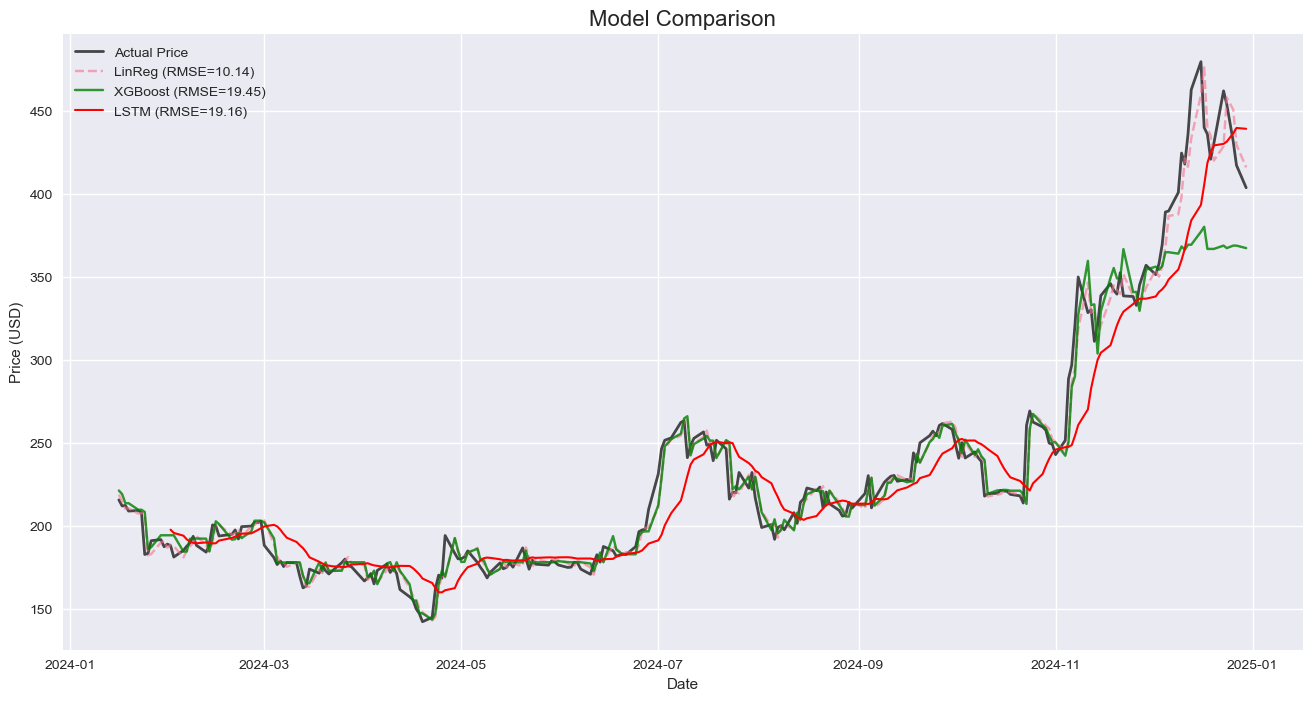

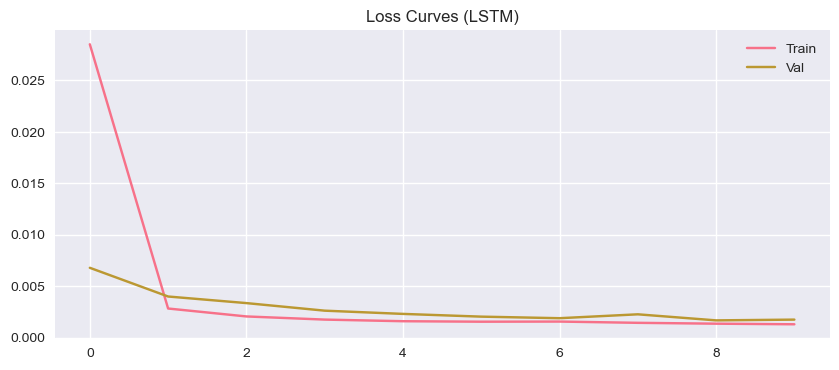

In [9]:
# Visualization

plt.figure(figsize=(16, 8))

# Dynamic date alignment
dates_test = df.index[-len(y_test):]
dates_lstm = df.index[-len(pred_lstm):]

# Plot curves
plt.plot(dates_test, y_test, label='Actual Price', color='black', linewidth=2, alpha=0.7)
plt.plot(dates_test, pred_lr, label=f'LinReg (RMSE={rmse_lr:.2f})', linestyle='--', alpha=0.6)
plt.plot(dates_test, pred_xgb, label=f'XGBoost (RMSE={rmse_xgb:.2f})', color='green', alpha=0.8)
plt.plot(dates_lstm, pred_lstm, label=f'LSTM (RMSE={rmse_lstm:.2f})', color='red', linewidth=1.5)

plt.title('Model Comparison', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Overfitting Check
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Curves (LSTM)')
plt.legend()
plt.show()

RMSE (via Returns): 10.96


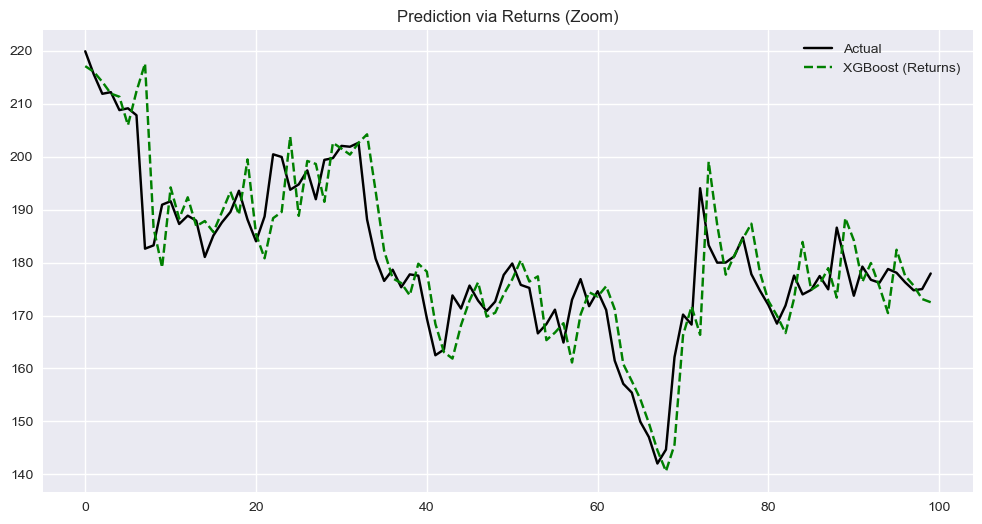

In [10]:
import xgboost as xgb

# bonus Return Prediction
# trying to predict % change rather than raw price

# Calculate returns
df['Return'] = df['Close'].pct_change()
df['Target_Return'] = df['Return'].shift(-1)
df.dropna(inplace=True)

# Features , Split
features_v2 = ['Return', 'Volume', 'RSI', 'MACD', 'Signal_Line']
X = df[features_v2]
y = df['Target_Return']

split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Train XGBoost on returns
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)
pred_returns = model_xgb.predict(X_test)

# Reconstruct Price: Close_current * (1 + Pred_return)
last_prices = df['Close'].iloc[split:].values
predicted_prices = last_prices * (1 + pred_returns)

# Real future prices (for comparison)
real_target_prices = df['Close'].shift(-1).iloc[split:].dropna().values

# Alignment & RMSE
min_len = min(len(predicted_prices), len(real_target_prices))
rmse_new = np.sqrt(np.mean((real_target_prices[:min_len] - predicted_prices[:min_len])**2))

print(f"RMSE (via Returns): {rmse_new:.2f}")

# Visualization (100-day Zoom)
plt.figure(figsize=(12,6))
plt.plot(real_target_prices[:100], label='Actual', color='black')
plt.plot(predicted_prices[:100], label='XGBoost (Returns)', color='green', linestyle='--')
plt.title("Prediction via Returns (Zoom)")
plt.legend()
plt.show()